[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/khetansarvesh/NLP/blob/main/Sentence-Level-Classification/In_Context_Learning_Movie_Review_Classification.ipynb)

In [2]:
# !pip install transformers # to get the finetuned models from hugging-face hub
# !pip install datasets

In [3]:
from collections import defaultdict, Counter
import json
from matplotlib import pyplot as plt
import numpy as np
import torch

In [4]:
inputs = "I'm excited to learn about Hugging Face Transformers!"

## **Tokenization : Distilbert-base-cased**

In [35]:
# Initialize the tokenizer
from transformers import DistilBertTokenizer, DistilBertTokenizerFast, AutoTokenizer

# Method 1 :
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-cased")      # written in Python
print(tokenizer)

# Method 2 :
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-cased")  # written in Rust
print(tokenizer)

# Method 3 : (most used)
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-cased") # Defaults to Fast
print(tokenizer)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


DistilBertTokenizer(name_or_path='distilbert-base-cased', vocab_size=28996, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
DistilBertTokenizerFast(name_or_path='distilbert-base-cased', vocab_size=28996, model_max_length=512, is_fast=True, padd

In [6]:
print(f'''Start :             {inputs}''')

input_tokens = tokenizer.tokenize(inputs)
print(f'''Tokenize :          {input_tokens}''')

input_ids = tokenizer.convert_tokens_to_ids(input_tokens)
start_token = tokenizer.cls_token_id
end_token = tokenizer.sep_token_id
print(f'''Input Ids :         [{start_token}]{input_ids}[{end_token}]''')

tokenized_inputs = tokenizer(inputs, return_tensors="pt")
print(f'''Tokens :            {tokenized_inputs}''')

decoded_str = tokenizer.decode(input_ids)
print(f'''Decoded :           {decoded_str}''')

Start :             I'm excited to learn about Hugging Face Transformers!
Tokenize :          ['I', "'", 'm', 'excited', 'to', 'learn', 'about', 'Hu', '##gging', 'Face', 'Transformers', '!']
Input Ids :         [101][146, 112, 182, 7215, 1106, 3858, 1164, 20164, 10932, 10289, 25267, 106][102]
Tokens :            {'input_ids': tensor([[  101,   146,   112,   182,  7215,  1106,  3858,  1164, 20164, 10932,
         10289, 25267,   106,   102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}
Decoded :           I'm excited to learn about Hugging Face Transformers!


In [7]:
input_t = tokenizer._tokenizer.encode(inputs)
print(f"Number of tokens:       {len(input_t)}")
print(f"Ids:                    {input_t.ids}")
print(f"Tokens:                 {input_t.tokens}")
print(f"Special tokens mask:    {input_t.special_tokens_mask}")

Number of tokens:       14
Ids:                    [101, 146, 112, 182, 7215, 1106, 3858, 1164, 20164, 10932, 10289, 25267, 106, 102]
Tokens:                 ['[CLS]', 'I', "'", 'm', 'excited', 'to', 'learn', 'about', 'Hu', '##gging', 'Face', 'Transformers', '!', '[SEP]']
Special tokens mask:    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]


In [8]:
# if you are adding padding to your question then it will be represented as 0 in the numeric form
print (f"Pad token: {tokenizer.pad_token} | Pad token id: {tokenizer.pad_token_id}")

Pad token: [PAD] | Pad token id: 0


In [9]:
# BATCH ENCODING : pass multiple strings into the tokenizer and pad them as you need
model_inputs = tokenizer(
                          [ "Hugging Face Transformers is great!",
                            "The quick brown fox jumps over the lazy dog.",
                            "Then the dog got up and ran away because she didn't like foxes."],
                          return_tensors="pt",
                          padding=True,
                          truncation=True)

print(model_inputs)

{'input_ids': tensor([[  101, 20164, 10932, 10289, 25267,  1110,  1632,   106,   102,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0],
        [  101,  1109,  3613,  3058, 17594, 15457,  1166,  1103, 16688,  3676,
           119,   102,     0,     0,     0,     0,     0,     0,     0],
        [  101,  1599,  1103,  3676,  1400,  1146,  1105,  1868,  1283,  1272,
          1131,  1238,   112,   189,  1176, 17594,  1279,   119,   102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}


In [10]:
# BATCH DECODING : Similary you can also do batch decoding
print(tokenizer.batch_decode(model_inputs.input_ids))
print()
print( "Batch Decode: (no special characters)")
print(tokenizer.batch_decode(model_inputs.input_ids, skip_spetial_tokens=True))

['[CLS] Hugging Face Transformers is great! [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]', '[CLS] The quick brown fox jumps over the lazy dog. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]', "[CLS] Then the dog got up and ran away because she didn't like foxes. [SEP]"]

Batch Decode: (no special characters)
['[CLS] Hugging Face Transformers is great! [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]', '[CLS] The quick brown fox jumps over the lazy dog. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]', "[CLS] Then the dog got up and ran away because she didn't like foxes. [SEP]"]


## **Modelling : Distilbert-base-cased**

In [20]:
# initialize the model
from transformers import AutoModelForSequenceClassification, DistilBertForSequenceClassification

# Method 1 :
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-cased',
                                                            num_labels=2,
                                                            output_attentions=True,  # by default this is false, if you want to see what attention values are for this example then put this to true
                                                            output_hidden_states=True # by default this is false, if you want to see what hidden states values are for this example then put this to true
                                                            )

# Method 2 :
model = AutoModelForSequenceClassification.from_pretrained('distilbert-base-cased', num_labels=2, output_attentions=True, output_hidden_states=True)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
# to get model parameters
list(model.named_parameters())[0]

('distilbert.embeddings.word_embeddings.weight',
 Parameter containing:
 tensor([[-2.5130e-02, -3.3044e-02, -2.4396e-03,  ..., -1.0848e-02,
          -4.6824e-02, -9.4855e-03],
         [-4.8244e-03, -2.1486e-02, -8.7145e-03,  ..., -2.6029e-02,
          -3.7862e-02, -2.4103e-02],
         [-1.6531e-02, -1.7862e-02,  1.0596e-03,  ..., -1.6371e-02,
          -3.5670e-02, -3.1419e-02],
         ...,
         [-9.6466e-03,  1.4814e-02, -2.9182e-02,  ..., -3.7873e-02,
          -4.6263e-02, -1.6803e-02],
         [-1.3170e-02,  6.5378e-05, -3.7222e-02,  ..., -4.3558e-02,
          -1.1252e-02, -2.2152e-02],
         [ 1.1905e-02, -2.3293e-02, -2.2506e-02,  ..., -2.7136e-02,
          -4.3556e-02,  1.0529e-04]], requires_grad=True))

In [26]:
# Initialize the model which will take above numerics as input
outputs = model(**tokenized_inputs)

In [28]:
# get prob values for negative or positive
print(outputs.logits)

prediction = torch.argmax(outputs.logits) # performing agr max to get prob sum = 1
print(prediction)

# get the sentiment
labels = ['NEGATIVE', 'POSITIVE']
print (f'''Sentiment : {labels[prediction]}''')

tensor([[-0.0608,  0.0542]], grad_fn=<AddmmBackward0>)
tensor(1)
Sentiment : POSITIVE


In [14]:
# Calculate the loss for this example
label = torch.tensor([1])
loss = torch.nn.functional.cross_entropy(outputs.logits, label)
print(loss)
loss.backward()

tensor(0.6444, grad_fn=<NllLossBackward0>)


In [29]:
# get hidden states from the model for this example
print("Hidden state size (per layer):  ", outputs.hidden_states[0].shape)
print(outputs.hidden_states[0])

Hidden state size (per layer):   torch.Size([1, 14, 768])
tensor([[[ 5.5207e-01,  1.7780e-01, -5.8549e-02,  ..., -1.5978e-02,
           2.0846e-01, -1.1543e-01],
         [-9.8524e-01,  2.7473e-01,  1.2516e-03,  ...,  1.3920e+00,
          -1.1383e+00,  5.2962e-01],
         [-1.2770e-01,  3.8453e-01, -1.0005e-01,  ...,  4.5097e-01,
           8.3359e-01,  1.5486e-01],
         ...,
         [ 7.7983e-01, -4.7915e-01,  2.5197e-01,  ...,  1.3934e+00,
          -1.7683e-01,  7.8183e-01],
         [-6.5844e-01,  1.0339e+00,  1.0016e+00,  ...,  7.8225e-01,
          -1.0915e+00, -7.1400e-02],
         [-3.9966e-01, -1.7272e-01,  2.2618e-01,  ...,  7.2809e-01,
          -1.2112e+00,  6.0205e-03]]], grad_fn=<NativeLayerNormBackward0>)


In [31]:
# and attention weights from the model for this example
print("Attention head size (per layer):", outputs.attentions[0].shape)
print(outputs.attentions[0])

Attention head size (per layer): torch.Size([1, 12, 14, 14])
tensor([[[[4.2812e-01, 1.1244e-01, 2.6608e-02,  ..., 3.0833e-02,
           3.2008e-02, 7.1765e-03],
          [2.3398e-01, 1.7368e-03, 1.4502e-01,  ..., 2.6525e-02,
           9.5912e-02, 8.0087e-03],
          [1.7609e-01, 7.7847e-02, 3.4122e-02,  ..., 6.5280e-02,
           1.0054e-01, 9.5240e-04],
          ...,
          [4.0258e-01, 2.0259e-02, 8.6414e-02,  ..., 1.0951e-01,
           9.1171e-02, 6.0883e-03],
          [1.3578e-01, 1.5324e-02, 4.9096e-02,  ..., 3.8419e-02,
           2.8369e-02, 1.1635e-03],
          [5.9166e-05, 5.9159e-06, 5.0314e-04,  ..., 1.3953e-05,
           1.5495e-05, 9.9903e-01]],

         [[6.3381e-01, 2.8069e-02, 2.1211e-02,  ..., 3.6605e-02,
           2.5252e-02, 6.4035e-02],
          [2.8908e-01, 6.3247e-01, 2.5697e-02,  ..., 1.2350e-04,
           4.6913e-05, 4.9882e-04],
          [3.1141e-01, 5.2640e-01, 9.2784e-02,  ..., 2.3485e-04,
           6.1229e-04, 6.9438e-03],
          ...

['[CLS]', 'Hu', '##gging', 'Face', 'Transformers', 'is', 'great', '!', '[SEP]']


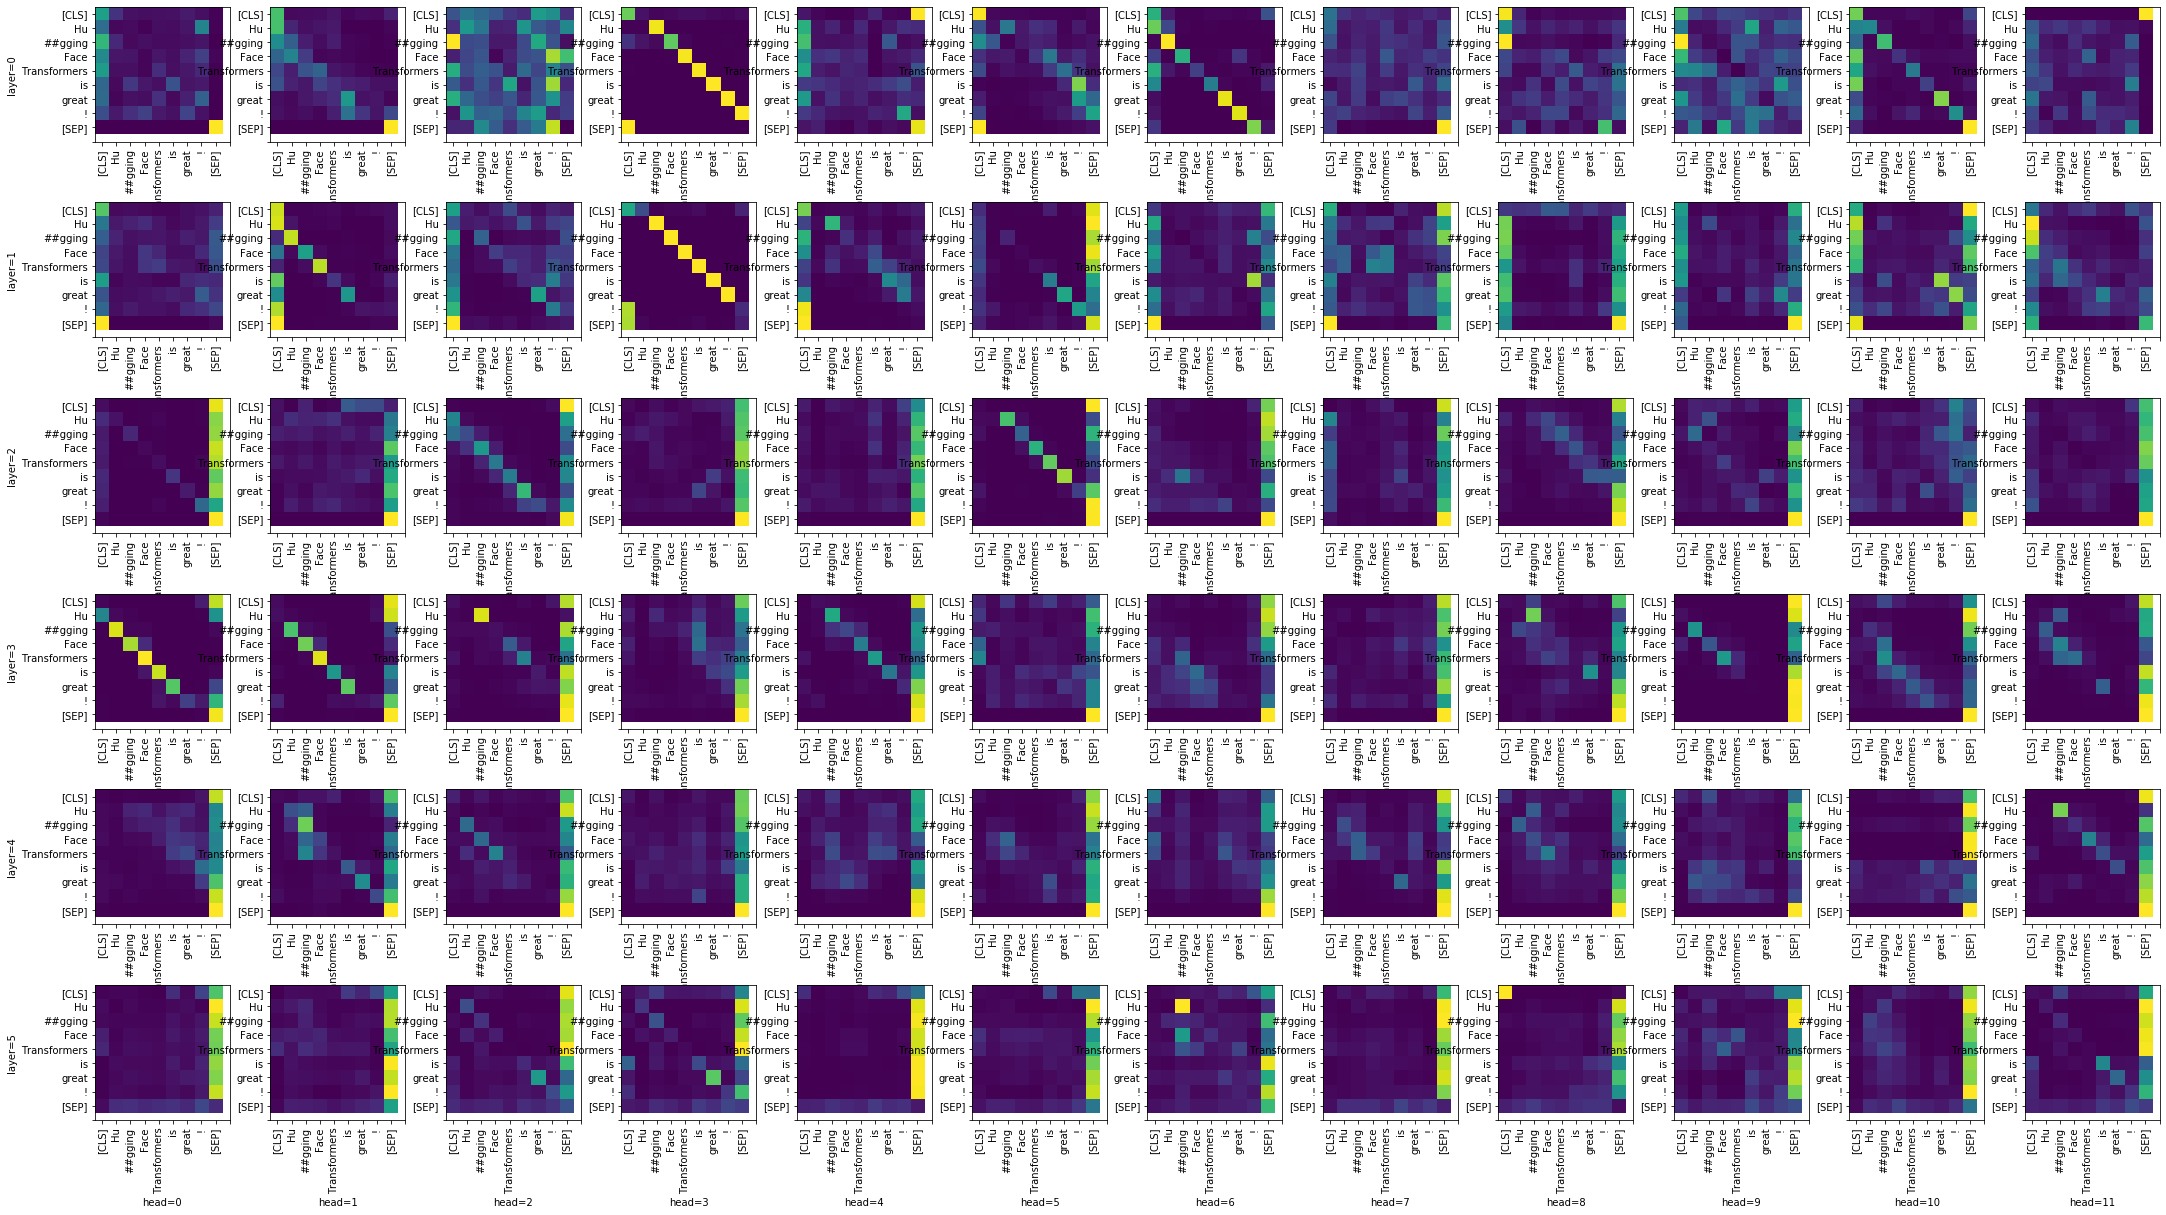

In [ ]:
tokens = tokenizer.convert_ids_to_tokens(model_inputs.input_ids[0])
print(tokens)

n_layers = len(outputs.attentions)
n_heads = len(outputs.attentions[0][0])
fig, axes = plt.subplots(6, 12)
fig.set_size_inches(18.5*2, 10.5*2)
for layer in range(n_layers):
    for i in range(n_heads):
        axes[layer, i].imshow(outputs.attentions[layer][0, i])
        axes[layer][i].set_xticks(list(range(10)))
        axes[layer][i].set_xticklabels(labels=tokens, rotation="vertical")
        axes[layer][i].set_yticks(list(range(10)))
        axes[layer][i].set_yticklabels(labels=tokens)

        if layer == 5:
            axes[layer, i].set(xlabel=f"head={i}")
        if i == 0:
            axes[layer, i].set(ylabel=f"layer={layer}")

plt.subplots_adjust(wspace=0.3)
plt.show()